# Libraries

In [1]:
# General
import pandas as pd
import numpy as np

# Data Management
from dataclasses import dataclass, field
from collections import namedtuple
import pickle

# Stats
from scipy.integrate import simpson

# Graphing
import matplotlib.pyplot as plt

# Import

Declare Data Structures to hold our data

In [2]:
coordinates = namedtuple("coordinates", ["lat", "lon"])

@dataclass
class class_data:
    name: str
    fluxsat: pd.DataFrame
    climate: pd.DataFrame
    stats: dict
    coords: coordinates

@dataclass
class aes:
    units: dict
    longnames: dict
    abbreviations: dict
    colours: dict

Populate data structures

In [3]:
# Populate site-specific data structure
df_loc = {
    "se_st1": class_data(
        name = "Abisko-Stordalen Grassland",
        fluxsat = pd.read_csv("gppe/se_st1_satellite-gppe_2025-06-03"),
        climate = pd.read_csv("../data/processed/se_st1_climate.csv"),
        stats = {},
        coords = coordinates(68.35415, 19.050333),
    ),
    "se_sto": class_data(
        name = "Abisko-Stordalen Palsa Bog",
        fluxsat = pd.read_csv("gppe/se_sto_satellite-gppe_2025-06-03"),
        climate = pd.read_csv("../data/processed/se_sto_climate.csv"),
        stats = {},
        coords = coordinates(68.35594288, 19.04520892),
    ),
    "fi_ken": class_data(
        name = "Kenttärova",
        fluxsat = pd.read_csv("gppe/fi_ken_satellite-gppe_2025-06-03"),
        climate = pd.read_csv("../data/processed/fi_ken_climate.csv"),
        stats = {},
        coords = coordinates(67.98721, 24.24301),
    ),
    "fi_sod": class_data(
        name = "Sodankylä",
        fluxsat = pd.read_csv("gppe/fi_sod_satellite-gppe_2025-06-03"),
        climate = pd.read_csv("../data/processed/fi_sod_climate.csv"),
        stats = {},
        coords = coordinates(67.36239, 26.63859),
    ),
    "fi_var": class_data(
        name = "Varrio",
        fluxsat = pd.read_csv("gppe/fi_var_satellite-gppe_2025-06-03"),
        climate = pd.read_csv("../data/processed/fi_var_climate.csv"),
        stats = {},
        coords = coordinates(67.7549, 29.61),
    )
}

# Import Atmospheric Indices
atmos = pd.read_csv("../data/processed/atmos.csv")

for key, item in df_loc.items():
    item.climate["date"] = pd.to_datetime(item.climate["Unnamed: 0"]).dt.date
    item.fluxsat["date"] = pd.to_datetime(item.fluxsat["Unnamed: 0"]).dt.date
    
    item.climate.set_index("date", inplace = True)
    item.fluxsat.set_index("date", inplace = True)
    
    item.climate.rename_axis(None, inplace = True)
    item.fluxsat.rename_axis(None, inplace = True)
    
    item.fluxsat["datetime"] = pd.to_datetime(item.fluxsat["Unnamed: 0"])
    item.fluxsat.drop("Unnamed: 0", inplace = True, axis = 1)
    item.climate.drop("Unnamed: 0", inplace = True, axis = 1)
    
atmos["date"] = pd.to_datetime(atmos["Unnamed: 0"]).dt.date
atmos.set_index("date", inplace = True)
atmos.rename_axis(None, inplace = True)
atmos.drop("Unnamed: 0", inplace = True, axis = 1)

# Processing

Combine satellite/GPPe, climate, and NAO/AO data by dates to get a daily paired dataset

In [4]:
daily = pd.merge(
    df_loc["se_st1"].climate,
    df_loc["se_st1"].fluxsat,
    how = "inner",
    left_index = True,
    right_index = True,
    #suffixes = ("_climate", "_fluxsat")
)
daily.index = pd.to_datetime(daily.index)

daily = pd.merge(
    daily,
    atmos,
    how = "outer", # inner will drop rows without matched timestamps = missing data e.g. missing summer temps for se_st1
    left_index = True,
    right_index = True
)
daily.index = pd.to_datetime(daily.index)

daily = daily.loc[pd.Timestamp("2000-01-01"):]

In [5]:
daily

,precipitation,temperature,snowdepth,blue,blue_asm,blue_contrast,blue_corr,blue_dent,blue_diss,blue_dvar,...,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,month_of_year_sin,month_of_year_cos,gppe,datetime,nao,ao
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.061000,2.036496
2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.154000,1.531662
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.330000,1.447427
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.360000,1.191186
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.995000,0.638368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,-0.456126,0.338938
2025-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,-0.527314,-0.273034
2025-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,-0.634172,-0.722893
2025-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,-0.598284,-0.835127


Resample into different time frequencies

In [203]:
def calc_auc(group):
    time_seconds = (group.index.day - group.index.day.min()) # Take the minimum time away from the each timestep in the day and convert to seconds so we are in the same units as GPP.
    #auc = np.trapz(group["gpp"].values, x = time_seconds) # switch to undeprecated version or try simpsons
    auc = simpson(y = group["ndvi"].values, x = time_seconds)#time_seconds) # this actually makes a big (good ~0.1) difference to the model r2 value!
    return pd.Series({"ndvi": auc}) # Return as pd.Series so we get a dataframe
    # Sklearn method: auc(time_seconds, group["gpp"]). Requires more than 1 val per day which we can't quite guarantee.

In [204]:
test = daily.resample("MS").apply(calc_auc)

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import simpson

def calc_auc(group):
    group = group.dropna()
    
    # Use days since the beginning of the group as x-axis
    days_since_start = (group.index - group.index.min()).days
    
    #if len(group) < 3:
    #    return pd.Series({"ndvi": np.nan})  # Simpson needs at least 3 pointss
    
    auc = simpson(y=group["ndvi"].values, x=days_since_start)
    return pd.Series({"ndvi": auc})

# Resample daily NDVI data to monthly, and apply the integration
test = daily.resample("MS").apply(calc_auc)

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [229]:
def calc_auc(group):
    # drop NaNs directly (no subset needed because it's a Series)
    group = group.dropna()

    days_since_start = (group.index - group.index.min()).days
    
    if len(group) < 3:
        return pd.Series({"ndvi": np.nan})
    
    auc = simpson(y=group.values, x=days_since_start)
    return pd.Series({"ndvi": auc})

test = daily["ndvi"].resample("MS").apply(calc_auc)

In [231]:
test = pd.DataFrame(test)

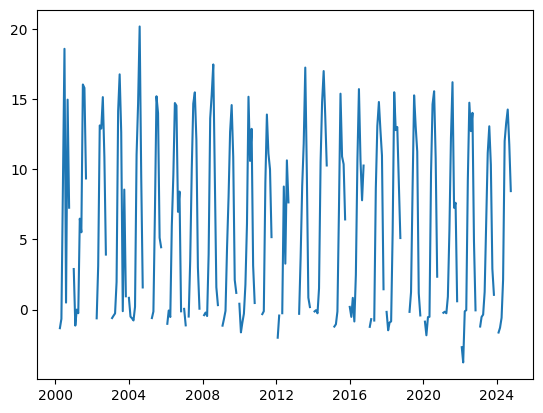

In [232]:
plt.plot(test["ndvi"])

In [ ]:
# An old version that doesn't do min max median or quartiles
#def resampler(daily, timeframe, drop_cat_cols=["platform_id"]):
#    daily = daily.copy()
#    
#    # Compute snow differences
#    daily["diff"] = daily["snowdepth"].diff()
#    daily["snowfall"] = daily["diff"].clip(lower=0)
#    daily["snowmelt"] = (-daily["diff"]).clip(lower=0)
#
#    # Define seasonal grouping
#    if timeframe == "season":
#        def get_season_start(date):
#            year = date.year
#            if date.month in [3, 4, 5]:
#                return pd.Timestamp(f"{year}-03-01") # first day of season
#            elif date.month in [6, 7, 8]:
#                return pd.Timestamp(f"{year}-06-01")
#            elif date.month in [9, 10, 11]:
#                return pd.Timestamp(f"{year}-09-01")
#            else:  # Dec, Jan, Feb
#                season_year = year if date.month != 12 else year + 1
#                return pd.Timestamp(f"{season_year - 1}-12-01")
#
#        season_start = daily.index.map(get_season_start)
#        
#        # Total sums
#        rs_gppe = daily.groupby(season_start)["gppe"].sum()
#        rs_precip = daily.groupby(season_start)["precipitation"].sum()
#        rs_snowfall = daily.groupby(season_start)["snowfall"].sum()
#        rs_snowmelt = daily.groupby(season_start)["snowmelt"].sum()
#
#        # Means
#        rs_means = daily.drop(columns=drop_cat_cols + ["diff", "snowfall", "snowmelt"]).groupby(season_start).mean()
#
#    else:
#        # Use regular resampling
#        rs_gppe = daily["gppe"].resample(timeframe).sum()
#        rs_precip = daily["precipitation"].resample(timeframe).sum()
#        rs_snowfall = daily["snowfall"].resample(timeframe).sum()
#        rs_snowmelt = daily["snowmelt"].resample(timeframe).sum()
#        rs_means = daily.drop(columns=drop_cat_cols + ["diff", "snowfall", "snowmelt"]).resample(timeframe).mean()
#
#    # Recombine
#    result = rs_means.join(rs_gppe.rename("gppe_sum")) \
#                     .join(rs_precip.rename("precipitation_sum")) \
#                     .join(rs_snowfall.rename("snowfall")) \
#                     .join(rs_snowmelt.rename("snowmelt"))
#    
#    return result

def calc_auc(group):
    group = group.dropna()

    days_since_start = (group.index - group.index.min()).days # time diff since start in days
    
    if len(group) < 3: # simpson must have atleast 3 points
        return pd.Series({"ndvi": np.nan})
    
    auc = simpson(y = group.values, x = days_since_start)
    return pd.Series({"ti_ndvi": auc})


def resampler(daily, timeframe, drop_cat_cols = ["platform_id"]):
    daily = daily.copy()

    # Compute snow differences
    daily["diff"] = daily["snowdepth"].diff()
    daily["snowfall"] = daily["diff"].clip(lower=0)
    daily["snowmelt"] = (-daily["diff"]).clip(lower=0)

    # Columns to apply statistics to
    stats_cols = daily.drop(columns = drop_cat_cols #+ ["diff", "snowfall", "snowmelt", "gppe", "precipitation"]
                            , errors = "ignore").columns

    # make aggregation functions into a list
    agg_funcs = [
        "mean",
        "min",
        "median",
        "max",
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ]
    agg_func_names = ["mean", "min", "median", "max", "q05", "q95"]

    # Make our season grouper function
    if timeframe == "season":
        def get_season_start(date):
            year = date.year
            if date.month in [3, 4, 5]:
                return pd.Timestamp(f"{year}-03-01")
            elif date.month in [6, 7, 8]:
                return pd.Timestamp(f"{year}-06-01")
            elif date.month in [9, 10, 11]:
                return pd.Timestamp(f"{year}-09-01")
            else:
                season_year = year if date.month != 12 else year + 1
                return pd.Timestamp(f"{season_year - 1}-12-01")

        season_start = daily.index.map(get_season_start)
        grouped = daily.groupby(season_start)

    else:
        grouped = daily.resample(timeframe)

    # Find means, quartiles, etc.
    rs_stats = grouped[stats_cols].agg(agg_funcs)
    rs_stats.columns = pd.MultiIndex.from_product([stats_cols, agg_func_names])

    # Calc sums
    rs_gppe = grouped["gppe"].sum()
    rs_precip = grouped["precipitation"].sum()
    rs_snowfall = grouped["snowfall"].sum()
    rs_snowmelt = grouped["snowmelt"].sum()
    
    # Time-integrated NDVI (for comparison to GPPe)
    #ndvi_auc = grouped["ndvi"].apply(calc_auc)
    ndvi_auc = grouped["ndvi"].agg(calc_auc)

    # Combine
    result = pd.concat([rs_stats], axis = 1)
    result[("gppe", "sum")] = rs_gppe
    result[("precipitation", "sum")] = rs_precip
    result[("snowfall", "")] = rs_snowfall
    result[("snowmelt", "")] = rs_snowmelt
    result[("ti_ndvi", "")] = ndvi_auc

    # flatten col names
    result.columns = ["_".join(filter(None, col)) for col in result.columns]

    return result

In [16]:
def pretty_seasons(df):
    numerical_month = df.index.month

    month_to_season = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    
    df["season"] = numerical_month.map(month_to_season)
    
    season_to_colour = {
        "Spring": "limegreen",
        "Summer": "gold",
        "Autumn": "coral",
        "Winter": "cornflowerblue"
    }

    df["season_colours"] = df["season"].map(season_to_colour)
    
    return df

In [17]:
monthly = pretty_seasons(resampler(daily = daily, timeframe = "MS"))
annually = resampler(daily = daily, timeframe = "YS")
seasonally = pretty_seasons(resampler(daily = daily, timeframe = "season"))
daily = pretty_seasons(daily) # must be last as this adds a categorical column

## Preview

### GPPe / Time

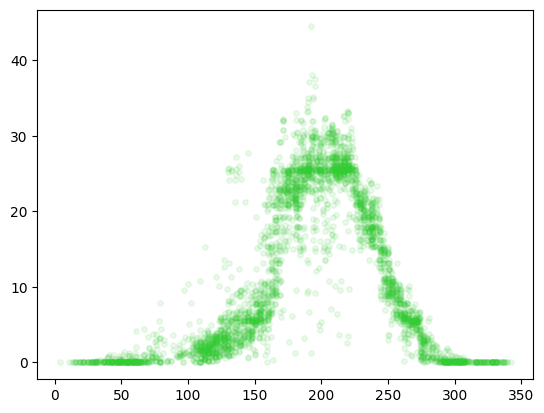

In [11]:
plt.scatter(daily["datetime"].dt.day_of_year, daily["gppe"], c = "limegreen", alpha = 0.1, s = 15)

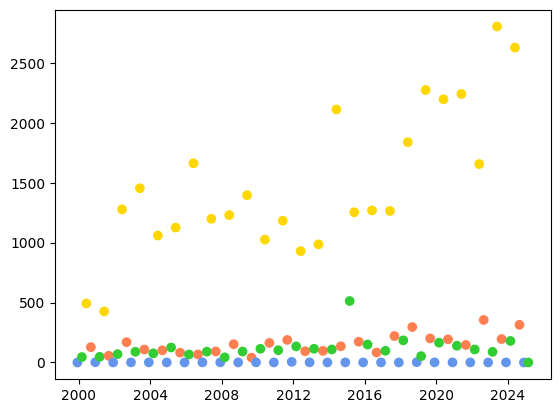

In [12]:
plt.scatter(seasonally.index, seasonally["gppe_sum"], c = seasonally["season_colours"])

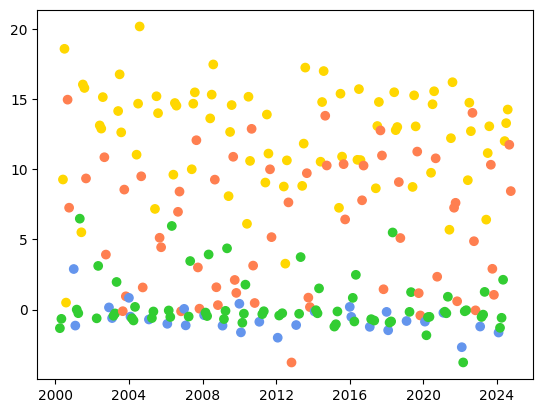

In [21]:
plt.scatter(monthly.index, monthly["ti_ndvi"], c = monthly["season_colours"])

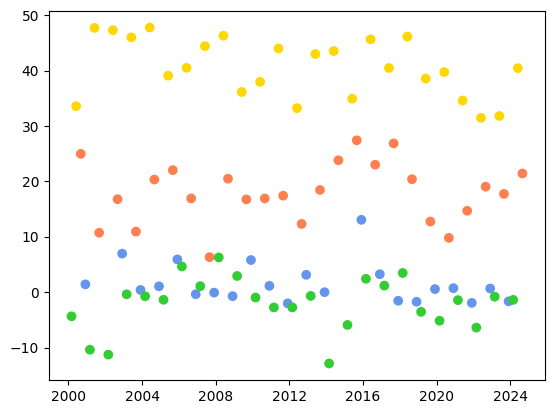

In [19]:
plt.scatter(seasonally.index, seasonally["ti_ndvi"], c = seasonally["season_colours"])

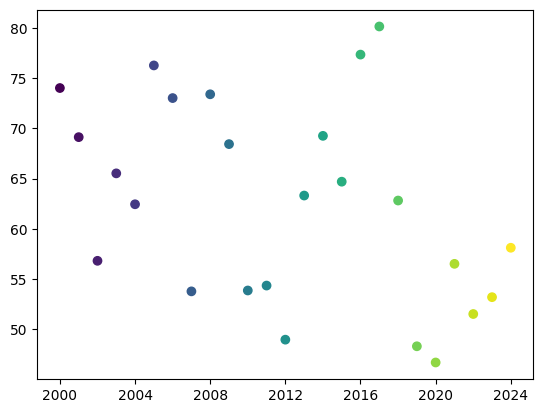

In [23]:
plt.scatter(annually.index, annually["ti_ndvi"], c = annually.index.year)

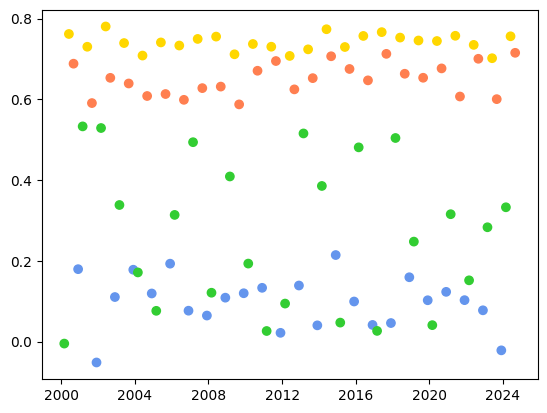

In [18]:
plt.scatter(seasonally.index, seasonally["ndvi_q95"], c = seasonally["season_colours"])

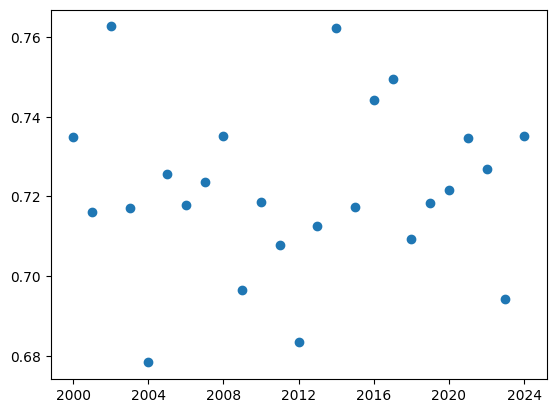

In [15]:
plt.scatter(annually.index, annually["ndvi_q95"], alpha = 1)

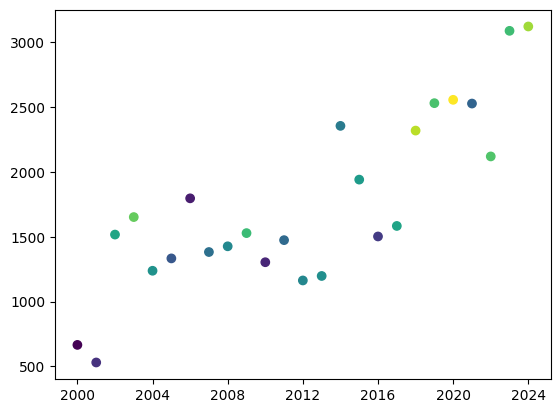

In [21]:
plt.scatter(annually.index, annually["gppe_sum"], c = np.log(annually["precipitation_sum"].shift(0)), alpha = 1)

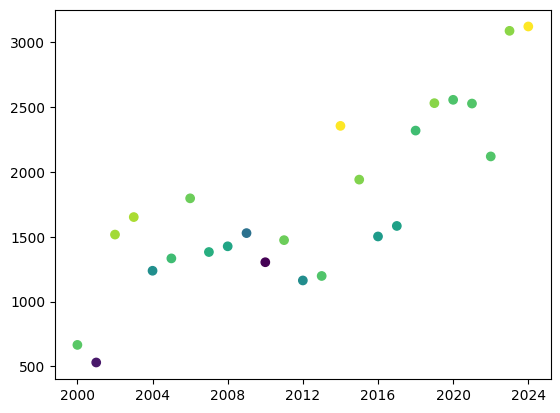

In [22]:
plt.scatter(annually.index, annually["gppe_sum"], c = annually["temperature_mean"], alpha = 1)

### Temperature

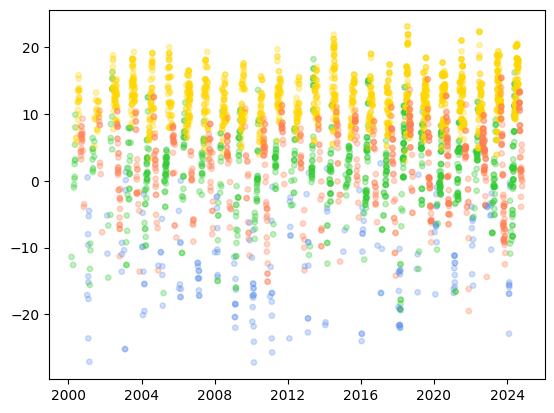

In [23]:
plt.scatter(daily.index, daily["temperature"], c = daily["season_colours"], alpha = 0.3, s = 15)

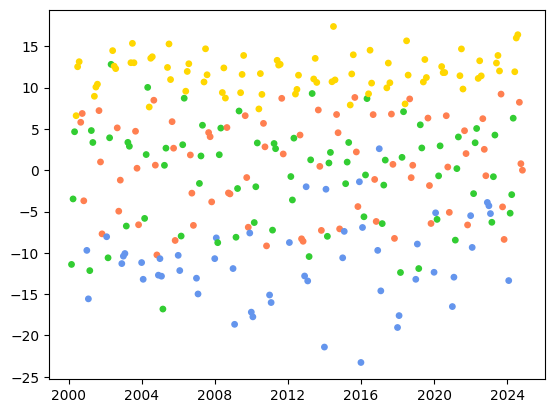

In [32]:
plt.scatter(monthly.index, monthly["temperature_mean"], c = monthly["season_colours"], alpha = 1, s = 15)

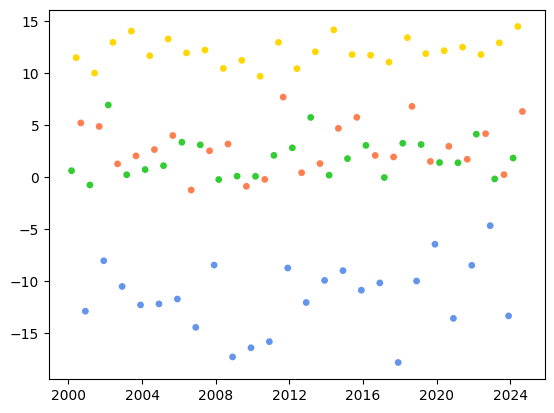

In [40]:
plt.scatter(seasonally.index, seasonally["temperature_mean"], c = seasonally["season_colours"], alpha = 1, s = 15)

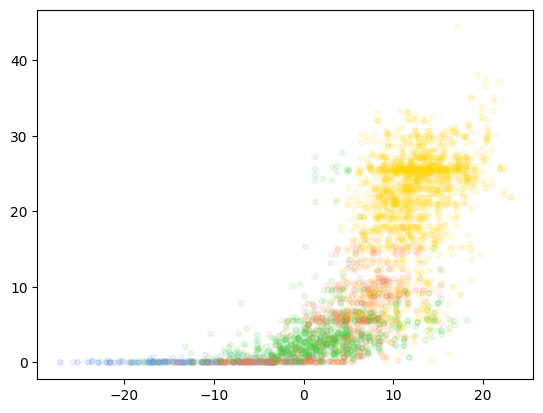

In [25]:
plt.scatter(daily["temperature"], daily["gppe"], c = daily["season_colours"], alpha = 0.1, s = 15)

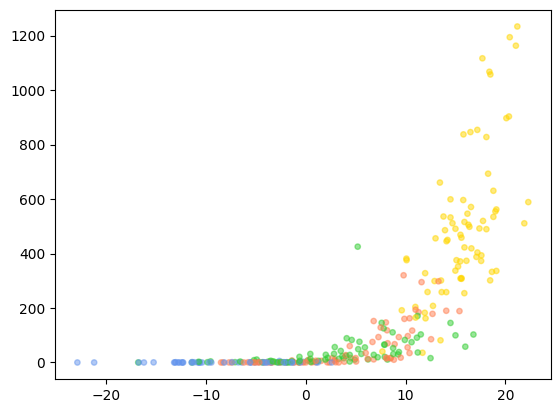

In [26]:
plt.scatter(monthly["temperature_q95"], monthly["gppe_sum"], c = monthly["season_colours"], alpha = 0.5, s = 15)

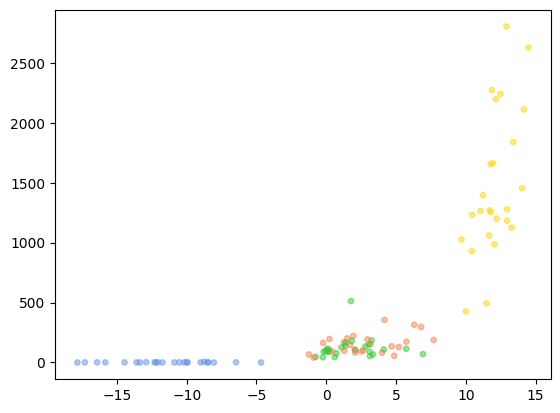

In [46]:
plt.scatter(seasonally["temperature_mean"], seasonally["gppe_sum"], c = seasonally["season_colours"], alpha = 0.5, s = 15)

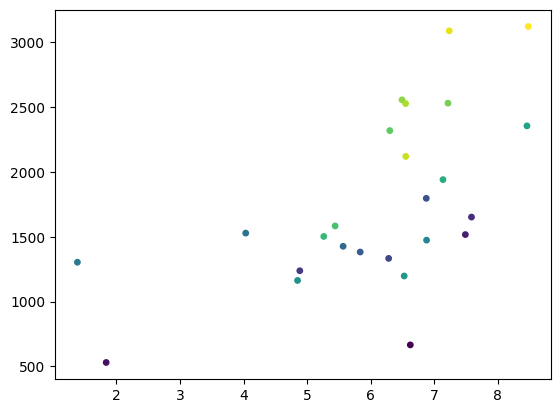

In [47]:
plt.scatter(annually["temperature_mean"], annually["gppe_sum"], c = annually.index.year, alpha = 1, s = 15)

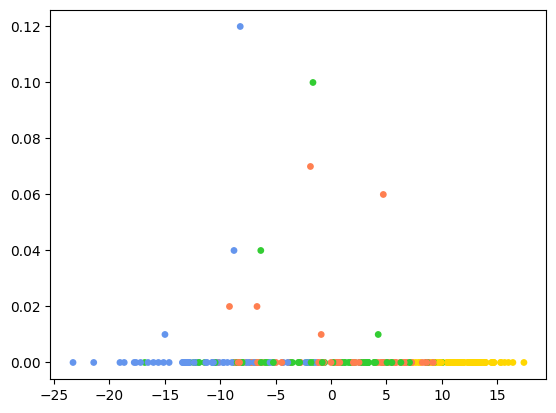

In [48]:
plt.scatter(monthly["temperature_mean"], monthly["snowfall"], c = monthly["season_colours"], alpha = 1, s = 15)

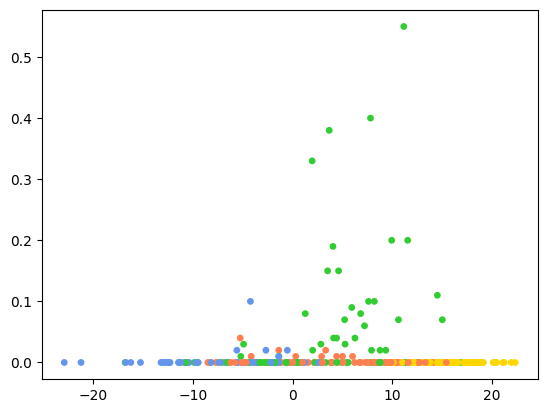

In [49]:
plt.scatter(monthly["temperature_q95"], monthly["snowmelt"], c = monthly["season_colours"], alpha = 1, s = 15)

### Precipitation

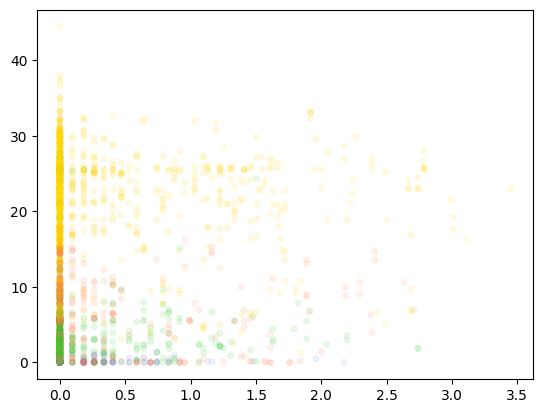

In [50]:
plt.scatter(np.log1p(daily["precipitation"]), daily["gppe"], c = daily["season_colours"], alpha = 0.1, s = 15)

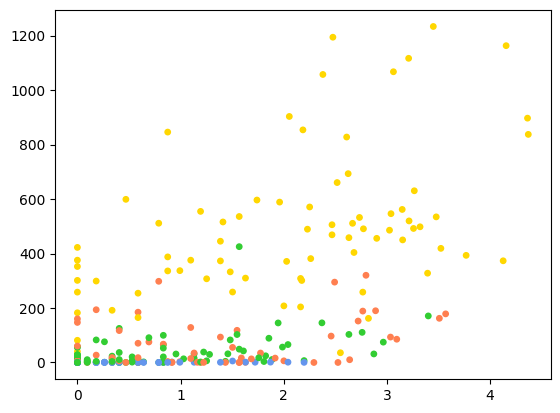

In [51]:
plt.scatter(np.log1p(monthly["precipitation_sum"]), monthly["gppe_sum"], c = monthly["season_colours"], alpha = 1, s = 15)

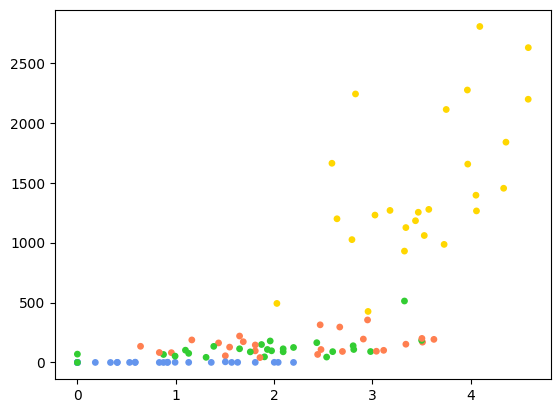

In [52]:
plt.scatter(np.log1p(seasonally["precipitation_sum"]), seasonally["gppe_sum"], c = seasonally["season_colours"], alpha = 1, s = 15)

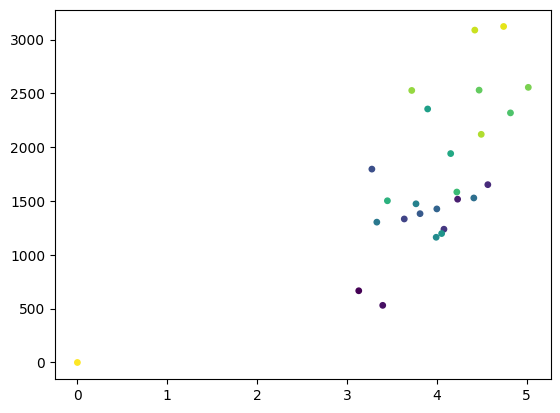

In [54]:
plt.scatter(np.log1p(annually["precipitation_sum"]), annually["gppe_sum"], c = annually.index.year, alpha = 1, s = 15)

### Snow

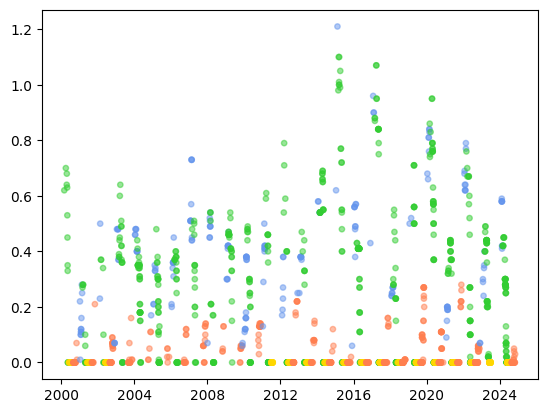

In [175]:
plt.scatter(daily.index, daily["snowdepth"], c = daily["season_colours"], alpha = 0.5, s = 15)

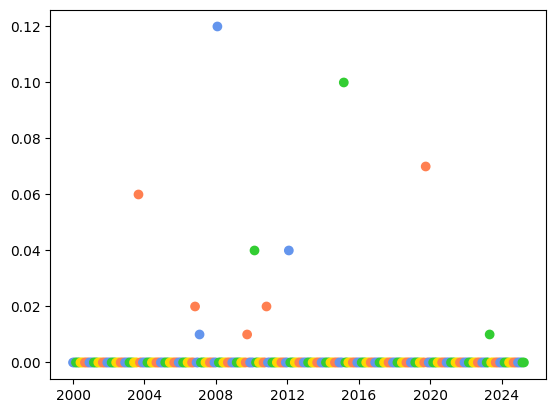

In [178]:
plt.scatter(monthly.index, monthly["snowfall"], c = monthly["season_colours"], alpha = 1)

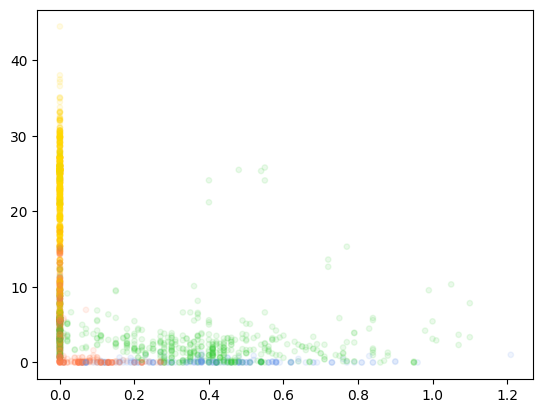

In [56]:
plt.scatter(daily["snowdepth"], daily["gppe"], c = daily["season_colours"], alpha = 0.1, s = 15)

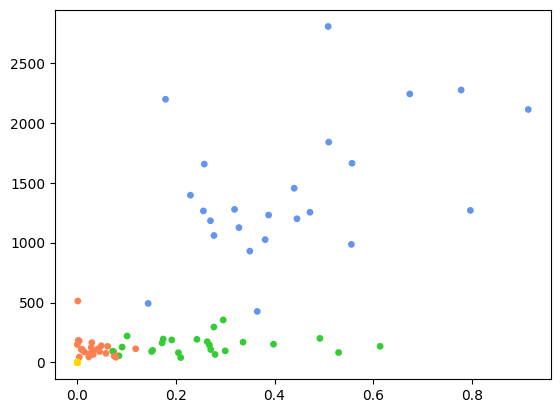

In [58]:
plt.scatter(seasonally["snowdepth_mean"], seasonally["gppe_sum"].shift(2), c = seasonally["season_colours"], alpha = 1, s = 15)

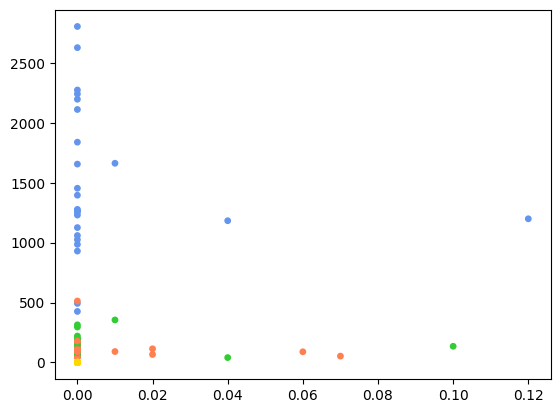

In [62]:
plt.scatter(seasonally["snowfall"], seasonally["gppe_sum"].shift(2), c = seasonally["season_colours"], alpha = 1, s = 15)

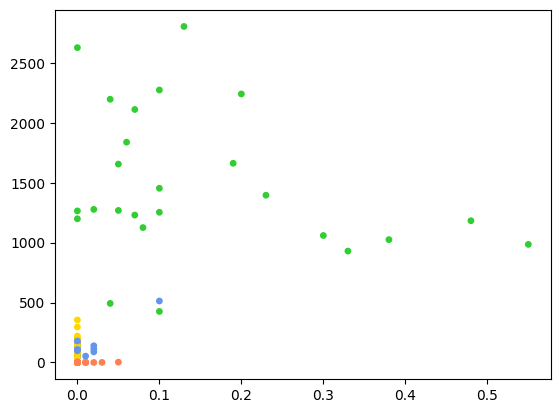

In [63]:
plt.scatter(seasonally["snowmelt"], seasonally["gppe_sum"].shift(3), c = seasonally["season_colours"], alpha = 1, s = 15)

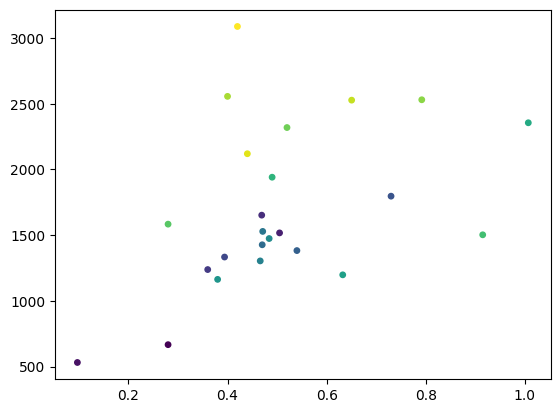

In [68]:
plt.scatter(annually["snowdepth_q95"], annually["gppe_sum"].shift(1), c = annually.index.year, alpha = 1, s = 15)

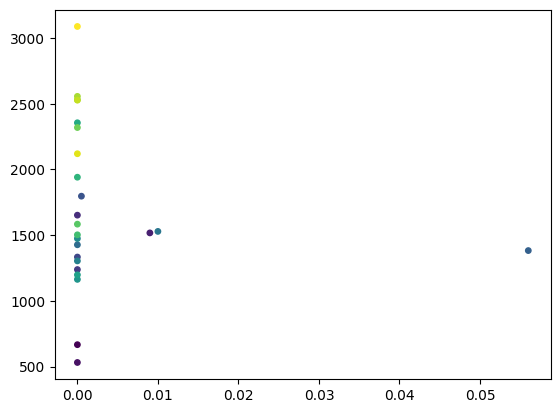

In [71]:
plt.scatter(annually["snowfall_q95"], annually["gppe_sum"].shift(1), c = annually.index.year, alpha = 1, s = 15)

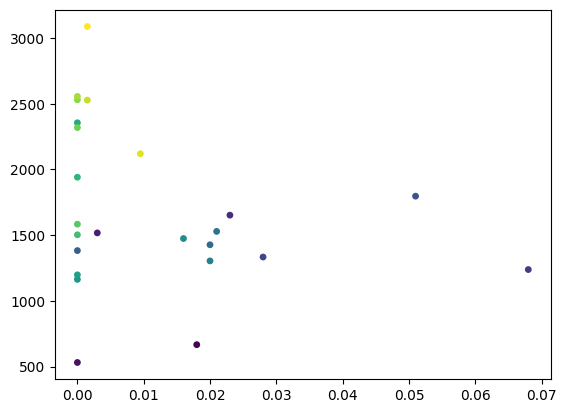

In [76]:
plt.scatter(annually["snowmelt_q95"], annually["gppe_sum"].shift(1), c = annually.index.year, alpha = 1, s = 15)

### NAO & AO

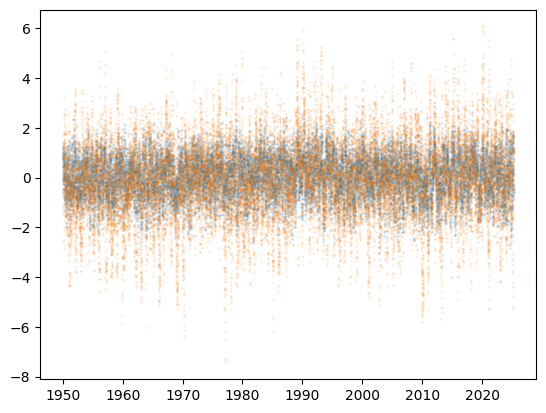

In [649]:
plt.scatter(atmos.index, atmos["nao"], alpha = 0.1, s = 1)
plt.scatter(atmos.index, atmos["ao"], alpha = 0.1, s = 1)

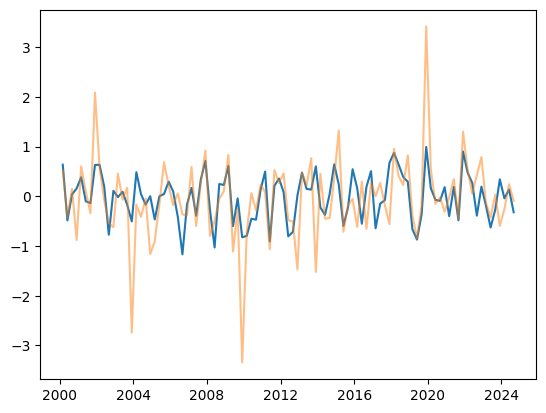

In [650]:
plt.plot(daily["nao"].resample("3MS").mean())
plt.plot(daily["ao"].resample("3MS").mean(), alpha = 0.5)

c:\Users\Laurie\Files\Education\Postgraduate Degree\Modules\GEOGM0062 Dissertation MSc Climate Change Science and Policy\Processing and Analysis\arctic-ecosystems\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


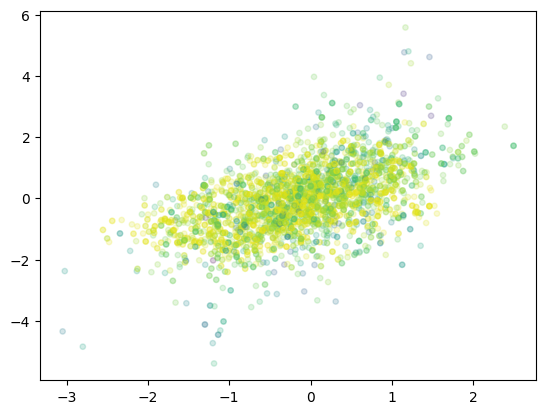

In [80]:
plt.scatter(daily["nao"], daily["ao"], c = np.log(daily["gppe"]), alpha = 0.2, s = 15)

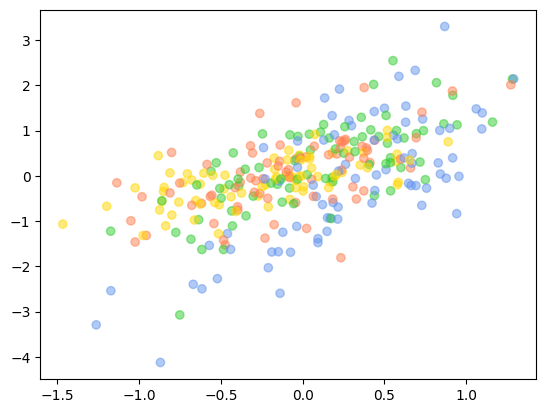

In [99]:
plt.scatter(monthly["nao_mean"], monthly["ao_mean"], c = monthly["season_colours"], alpha = 0.5)

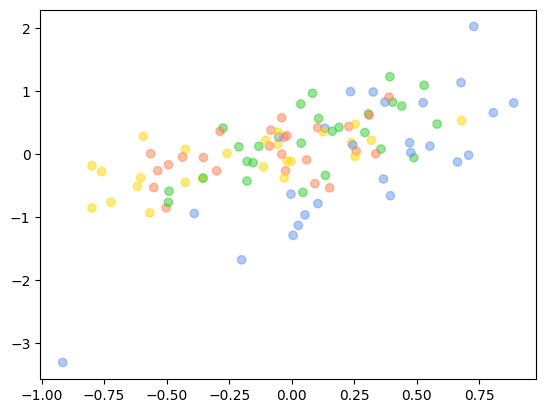

In [98]:
plt.scatter(seasonally["nao_mean"], seasonally["ao_mean"], c = seasonally["season_colours"], alpha = 0.5)

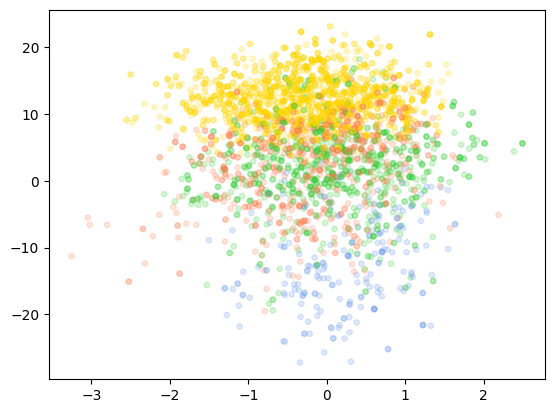

In [107]:
plt.scatter(daily["nao"], daily["temperature"], c = daily["season_colours"], alpha = 0.2, s = 15)

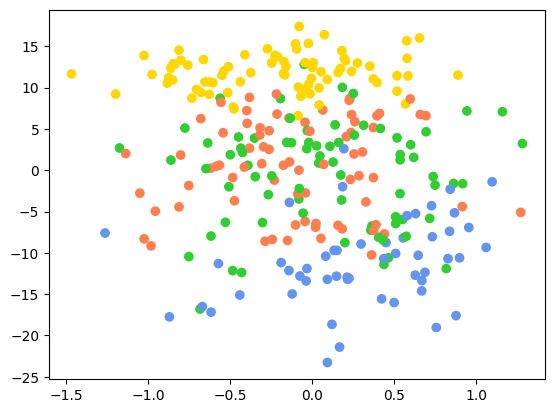

In [121]:
plt.scatter(monthly["nao_mean"], monthly["temperature_mean"].shift(0), c = monthly["season_colours"], alpha = 1)

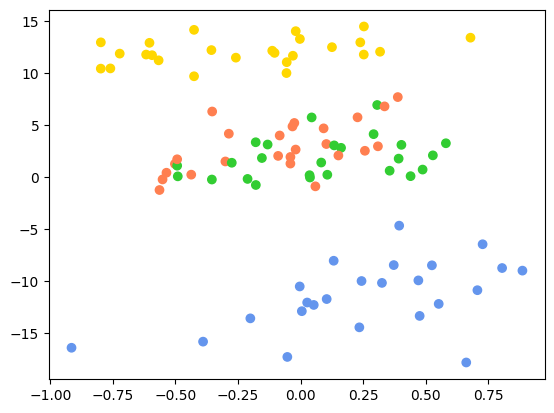

In [134]:
plt.scatter(seasonally["nao_mean"], seasonally["temperature_mean"].shift(0), c = seasonally["season_colours"], alpha = 1)

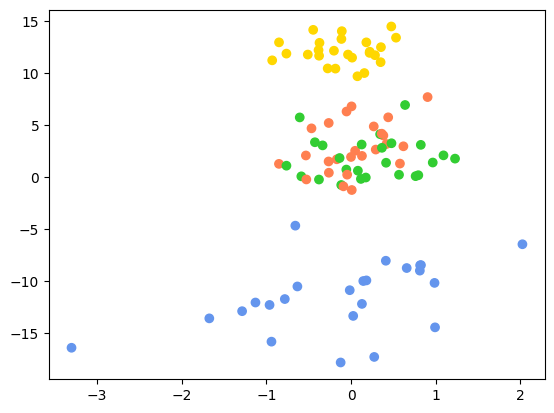

In [135]:
plt.scatter(seasonally["ao_mean"], seasonally["temperature_mean"].shift(0), c = seasonally["season_colours"], alpha = 1)

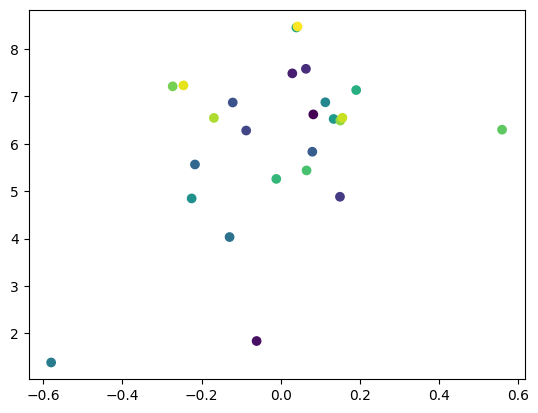

In [ ]:
plt.scatter(annually["nao_mean"], annually["temperature_mean"], c = annually.index.year, alpha = 1)

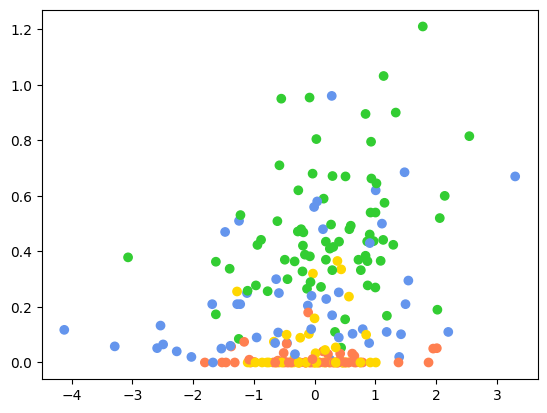

In [144]:
plt.scatter(monthly["ao_mean"], monthly["snowdepth_mean"].shift(1), c = monthly["season_colours"], alpha = 1)

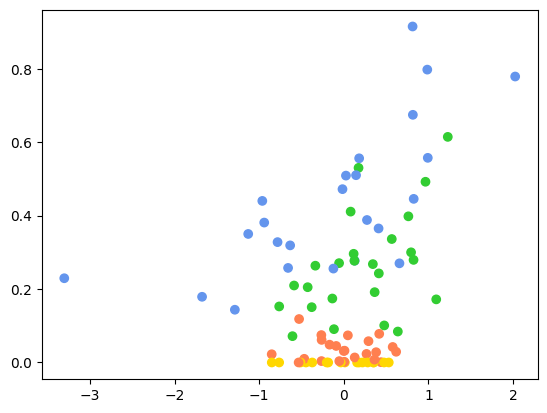

In [ ]:
plt.scatter(seasonally["ao_mean"], seasonally["snowdepth_mean"], c = seasonally["season_colours"], alpha = 1)

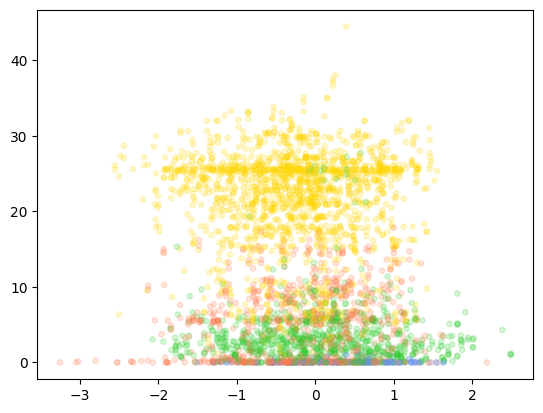

In [149]:
plt.scatter(daily["nao"], daily["gppe"], c = daily["season_colours"], alpha = 0.2, s = 15)

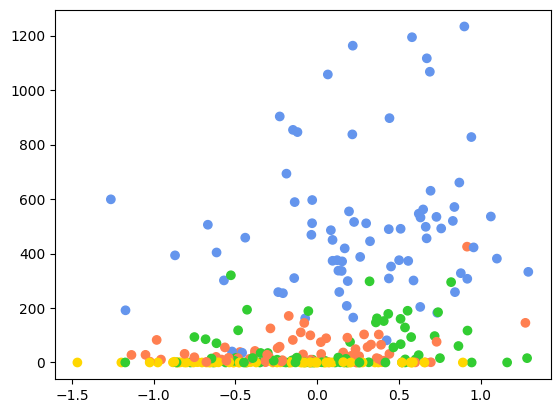

In [ ]:
plt.scatter(monthly["nao_mean"], monthly["gppe_sum"], c = monthly["season_colours"], alpha = 1)

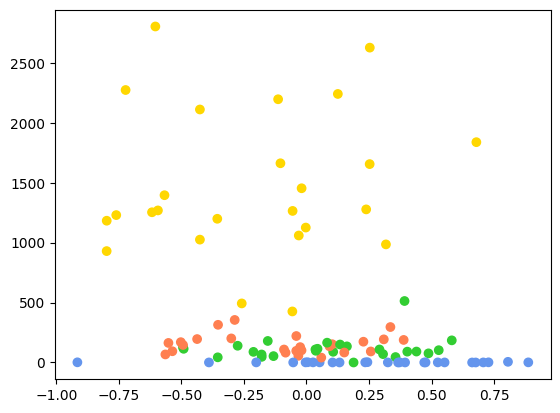

In [162]:
plt.scatter(seasonally["nao_mean"], seasonally["gppe_sum"], c = seasonally["season_colours"], alpha = 1)

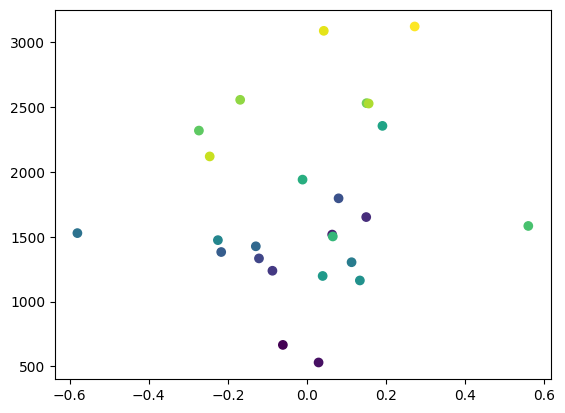

In [168]:
plt.scatter(annually["nao_mean"], annually["gppe_sum"].shift(1), c = annually.index.year, alpha = 1)

# Statistics

1. GPP correlate with climate variables
3. NOA/AO correlate with climate variables
3. GPP with NOA/AO correlate

# Figures

Save to: "../figures/"